check that any new vein is not super close to existing veins - investigate why this happens

In [1]:
!pip install networkx[default]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

In [3]:
veins = nx.DiGraph()
veins.add_node(0, x=0, y=0)

In [4]:
def resetSimulation(veins, auxinSources, x, y):
    veins = nx.DiGraph()
    veins.add_node(0, x=0, y=0)

    auxinSources = []

    # Create points for the curve
    t = np.linspace(0.0001, 1, 100)  # not including 0 because 0 is leaf stem not where leaf grows.
    x = np.sin(np.pi * t) * (1 - t)
    y = t
    # Create the mirror image by reversing the sign of x
    # This combines the right side (original x values) with the left side (-x values)
    x = np.concatenate([x, -x[::-1]])  # [::-1] reverses the array
    y = np.concatenate([y, y[::-1]])   # Mirror the y values too to complete the loop
    return veins, auxinSources, x, y

In [5]:
def getVeinPositionList(veins):
    x,y = [], []
    for i in veins.nodes():
        x.append(veins.nodes[i]['x'])
        y.append(veins.nodes[i]['y'])
    return x,y

In [6]:
def plot_leaf(x, y, veins, auxinSourceX, auxinSourceY):
    # Plot the complete leaf shape
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.plot(x, y)
    ax.set_title("Complete Leaf Shape")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.axis('equal')  # This ensures the aspect ratio is 1:1

    veinsX, veinsY = getVeinPositionList(veins)
    ax.plot(veinsX,veinsY, 'go')
    nx.draw_networkx_edges(veins, pos=dict(zip(veins.nodes, zip(veinsX, veinsY))), width=list(nx.get_edge_attributes(veins, 'width').values()), arrows=False, ax=ax)

    ax.plot(auxinSourceX, auxinSourceY, 'ro')
    plt.show()

In [7]:
def scaleGrowth(baseX, baseY, x, y, scalingFactor):
    x = baseX + scalingFactor * (x - baseX)
    y = baseY + scalingFactor * (y - baseY)
    return x, y

def growLeaf(baseX, baseY, x, y, timestep):
    # scalingFactor,growthOfScalingFactor = updateScalingFactor(scalingFactor, growthOfScalingFactor, deltaScalingFactor)
    scalingFactor = 1 + getGrowthForTimestep(timestep)
    x, y = scaleGrowth(baseX, baseY, x, y, scalingFactor)
    return x,y

In [8]:
baseX, baseY = 0.0, 0.0
sourceToVeinDistanceThreshold = 0.1
sourceToSourceDistanceThreshold = 0.1
distanceVeinGrows = 0.1
numberOfAuxinSources = 10
murraysLawExponent = 3

In [9]:
auxinSources = []

def getAuxinSourceX(auxinSources):
    return [x for x,y in auxinSources]

def getAuxinSourceY(auxinSources):
    return [y for x,y in auxinSources]

In [10]:
# Create points for the curve
t = np.linspace(0.0001, 1, 100)  # not including 0 because 0 is leaf stem not where leaf grows.
x = np.sin(np.pi * t) * (1 - t)
y = t
# Create the mirror image by reversing the sign of x
# This combines the right side (original x values) with the left side (-x values)
x = np.concatenate([x, -x[::-1]])  # [::-1] reverses the array
y = np.concatenate([y, y[::-1]])   # Mirror the y values too to complete the loop

In [11]:
scalingFactor = 1.0
growthOfScalingFactor = 0.01
# deltaScalingFactor = lambda f: max(f-max(0.1*f, 0.1), 0)
def deltaScalingFactor(sf):
    print(f'Current {sf}, new {max(sf-0.001, 0)}')
    return max(sf-0.001, 0)

def updateScalingFactor(scalingFactor, growthOfScalingFactor, deltaScalingFactor):
    growthOfScalingFactor = deltaScalingFactor(growthOfScalingFactor)
    scalingFactor += growthOfScalingFactor

    return scalingFactor, growthOfScalingFactor

def getGrowthForTimestep(timestep):
    if timestep > 10:
        return 0
    else:
        return 0.1

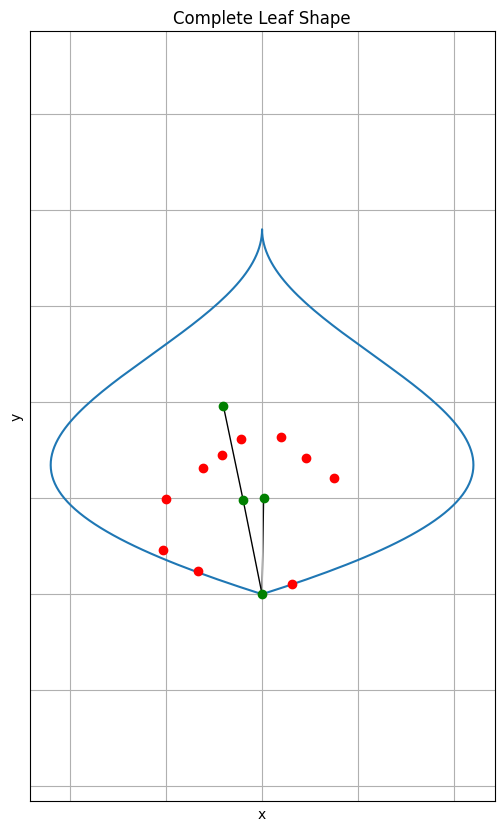

In [ ]:
# x, y, scalingFactor, growthOfScalingFactor = growLeaf(baseX, baseY, x, y, scalingFactor, growthOfScalingFactor, deltaScalingFactor)
# plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [12]:
def throwDart(x, y):
    xMin, xMax = np.min(x), np.max(x)
    randomX = np.random.uniform(xMin, xMax)
    xIdx = np.argsort(np.abs(x - randomX))[:2]
    yMin, yMax = np.min(y[xIdx]), np.max(y[xIdx])
    randomY = np.random.uniform(yMin, yMax)

    return randomX, randomY

def throwDartAtEdges(x, y):
    xSorted = x[np.argsort(x)]

    xMin, xMax = xSorted[0], xSorted[-1]
    randomX = np.random.uniform(xMin, xMax)

    xIdx = np.argsort(np.abs(x - randomX))[:2]
    yMin, yMax = np.min(y[xIdx]), np.max(y[xIdx])

    return randomX, random.choice([yMin, yMax])

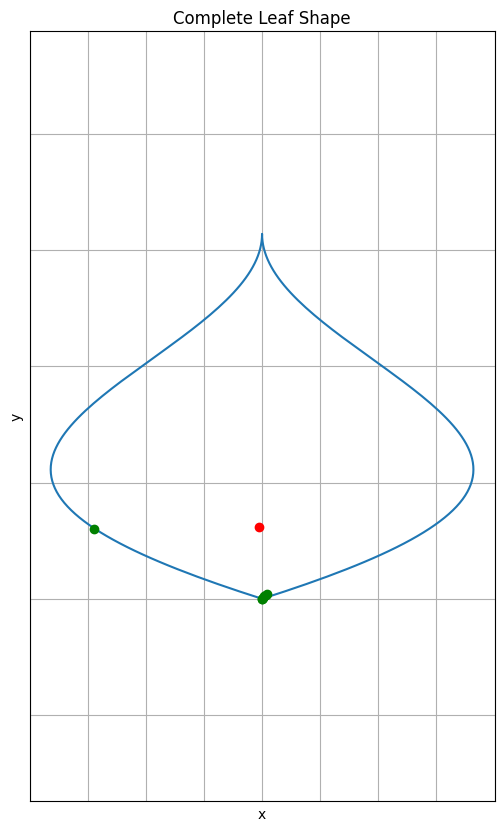

In [ ]:
# newVeinX, newVeinY = throwDartAtEdges(x, y)
# veins.add_node(veins.number_of_nodes(), x=newVeinX, y=newVeinY)
# plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [13]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [14]:
def checkNewSourceAgainstOtherVeins(veins, newSourceX, newSourceY, thresholdBirthDistance):
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], newSourceX, newSourceY) < thresholdBirthDistance:
            return False
    return True

def checkNewSourceAgainstOtherSources(auxinSources, newSourceX, newSourceY, thresholdDistance):
    for (x,y) in auxinSources:
        if distance(x, y, newSourceX, newSourceY) < thresholdDistance:
            return False
    return True

In [15]:
def removeSourcesCloseToVeins(veins, auxinSources, thresholdDistance):
    newAuxinSources = []
    for i in range(len(auxinSources)):
        isClose = False
        for j in range(len(veins.nodes)):
            if distance(veins.nodes[j]['x'], veins.nodes[j]['y'], auxinSources[i][0], auxinSources[i][1]) <= thresholdDistance:
                isClose = True
                break
        if not isClose:
            newAuxinSources.append(auxinSources[i])
    return newAuxinSources

In [16]:
def addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold):
    while True:
        newSourceX, newSourceY = throwDartAtEdges(x, y)

        if checkNewSourceAgainstOtherVeins(veins, newSourceX, newSourceY, sourceToVeinDistanceThreshold) and checkNewSourceAgainstOtherSources(auxinSources, newSourceX, newSourceY, sourceToSourceDistanceThreshold):
            # veins.add_node(veins.number_of_nodes(), x=newSourceX, y=newSourceY)
            auxinSources.append((newSourceX, newSourceY))
            break

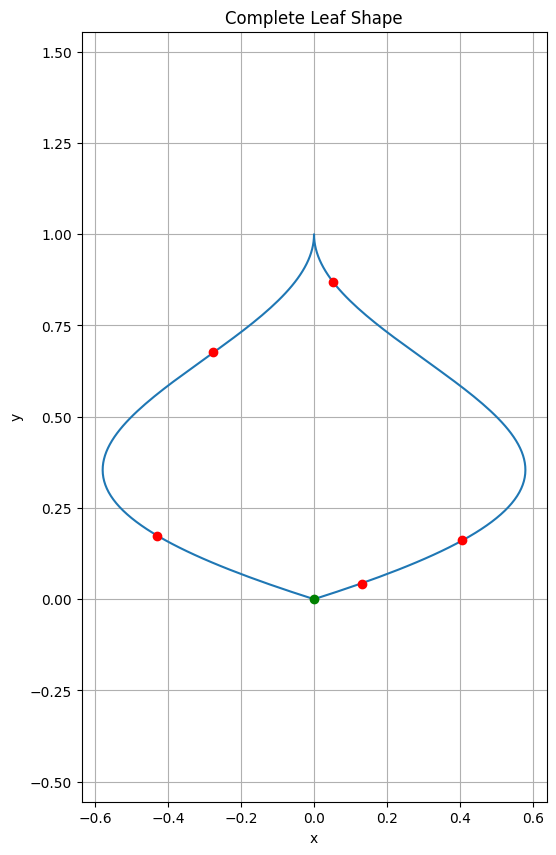

In [ ]:
for i in range(5):
    addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [82]:
def getBuckets(veins, auxinSources):
    buckets = [[] for i in range(veins.number_of_nodes())]

    for sourceX,sourceY in auxinSources:
        minDistance = np.inf
        minIdx = -1
        for i in veins.nodes():
            if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], sourceX, sourceY) < minDistance:
                minDistance = distance(veins.nodes[i]['x'], veins.nodes[i]['y'], sourceX, sourceY)
                minIdx = i

        buckets[minIdx].append((sourceX,sourceY))

    return buckets

In [114]:
def addVeinsForBuckets(buckets, veins, distanceVeinGrows):
    newVeinNodesAdded = []
    for bucketIdx, bucket in enumerate(buckets):
        if len(bucket) == 0:
            continue
        node = veins.nodes[bucketIdx]

        directionVectorX, directionVectorY = getDirectionVector(bucket, node['x'],  node['y'])

        print(f'Direction {directionVectorX}, {directionVectorY}')

        newVeinX = node['x'] + distanceVeinGrows * (directionVectorX / math.sqrt(directionVectorX**2 + directionVectorY**2))
        newVeinY = node['y'] + distanceVeinGrows * (directionVectorY / math.sqrt(directionVectorX**2 + directionVectorY**2))

        if checkDistanceToExistingVeins(veins, newVeinX, newVeinY):
            print(f'Buckets: {buckets}\ncurrent bucket {bucketIdx}: {bucket}')
            print(f'Direction vector {directionVectorX}, {directionVectorY}')
            print(f"node x: {node['x']}")
            print(f'distanceVeinGrows * (directionVectorX / math.sqrt(directionVectorX**2 + directionVectorY**2)) {distanceVeinGrows * (directionVectorX / math.sqrt(directionVectorX**2 + directionVectorY**2))}')
            print(f'newVeinX: {node["x"] + distanceVeinGrows * (directionVectorX / math.sqrt(directionVectorX**2 + directionVectorY**2))}')
            print(f"node y: {node['y']}")
            print(f'distanceVeinGrows * (directionVectorY / math.sqrt(directionVectorX**2 + directionVectorY**2)) {distanceVeinGrows * (directionVectorY / math.sqrt(directionVectorX**2 + directionVectorY**2))}')
            print(f'newVeinY: {node["y"] + distanceVeinGrows * (directionVectorY / math.sqrt(directionVectorX**2 + directionVectorY**2))}')

        veins.add_node(veins.number_of_nodes(), x=newVeinX, y=newVeinY)
        veins.add_edge(veins.number_of_nodes() - 1, bucketIdx, width=1)
        newVeinNodesAdded.append(veins.number_of_nodes() - 1)

    return newVeinNodesAdded

In [57]:
def checkDistanceToExistingVeins(veins, newVeinX, newVeinY):
    problem = False
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], newVeinX, newVeinY) == 0:
            print(f'Distance {distance(veins.nodes[i]["x"], veins.nodes[i]["y"], newVeinX, newVeinY)} : new vein ({newVeinX}, {newVeinY}) close to existing vein ({veins.nodes[i]["x"]}, {veins.nodes[i]["y"]})')
            problem = True

    return problem

In [118]:
def isNewVeinCloseToExistingVeins(veins, newVeinX, newVeinY, thresholdDistance):
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], newVeinX, newVeinY) < thresholdDistance:
            return True
    return False

def getDirectionVector(bucket, nodeX, nodeY):
    weights = np.linspace(0.3, 0.7, len(bucket))
    directionVectorX, directionVectorY = 0, 0
    for idx,(sourceX, sourceY )in enumerate(sorted(bucket, key=lambda a: distance(nodeX, nodeY, a[0], a[1]))):
        directionVectorX += weights[idx] * (sourceX - nodeX) / distance(nodeX, nodeY, sourceX, sourceY)
        directionVectorY += weights[idx] * (sourceY - nodeY) / distance(nodeX, nodeY, sourceX, sourceY)

    if abs(directionVectorX) + abs(directionVectorY) < 0.1:
        print(f'abs(directionVectorX) + abs(directionVectorY) < 0.1')
        print(f'before directionVectorX {directionVectorX}')
        print(f'directionVectorY {directionVectorY}')
        print(f'sorted list {sorted(bucket, key=lambda a: distance(nodeX, nodeY, a[0], a[1]))}')
        minDistance = sorted(bucket, key=lambda a: distance(nodeX, nodeY, a[0], a[1]))[0]
        print(f'minDistance {minDistance}')
        directionVectorX = (minDistance[0] - nodeX) / distance(nodeX, nodeY, minDistance[0], minDistance[1])
        directionVectorY = (minDistance[1] - nodeY) / distance(nodeX, nodeY, minDistance[0], minDistance[1])
        print(f'after directionVectorX {directionVectorX}')
        print(f'directionVectorY {directionVectorY}')

    if abs(directionVectorX) < 0.001:
        print(f'picking random x, before {directionVectorX}')
        directionVectorX += random.choice(bucket)[0]
        print(f'after {directionVectorX}')

    if abs(directionVectorY) < 0.001:
        print(f'picking random y, before {directionVectorY}')
        directionVectorY += random.choice(bucket)[1]
        print(f'after {directionVectorY}')



    return directionVectorX, directionVectorY

In [20]:
def updateWidthForNewVeinNodes(newVeinNodes, veins, murraysLawExponent):
    for newVeinNode in newVeinNodes:
        path = nx.shortest_path(veins, newVeinNode, 0)
        path_edges = list(zip(path, path[1:]))
        for i in range(1, len(path_edges)):
            veins.edges[path_edges[i]]['width'] = min(10, murraysLaw(path_edges[i], veins, murraysLawExponent))

    return veins

def murraysLaw(veinEdge, veins, murraysLawExponent):
    veinEdgeOrigin = veinEdge[0]

    total = 0
    for e in veins.in_edges(veinEdgeOrigin):
        total += veins.edges[e]['width']**murraysLawExponent

    return math.sqrt(total)

In [ ]:
print(f'Before removing sources: {auxinSources}')
auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
print(f'After removing sources: {auxinSources}')

Before removing sources: [(0.05219949365885268, 0.8686999999999999), (-0.2770856602387496, 0.6768)]
After removing sources: [(0.05219949365885268, 0.8686999999999999), (-0.2770856602387496, 0.6768)]


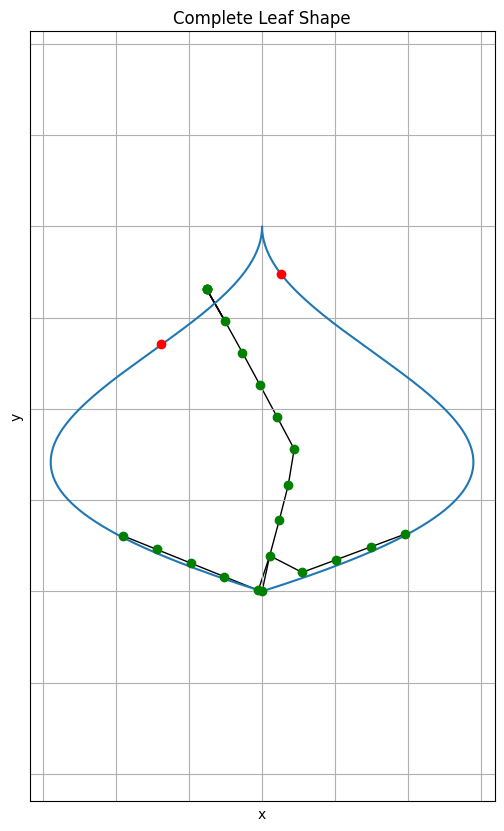

In [ ]:
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

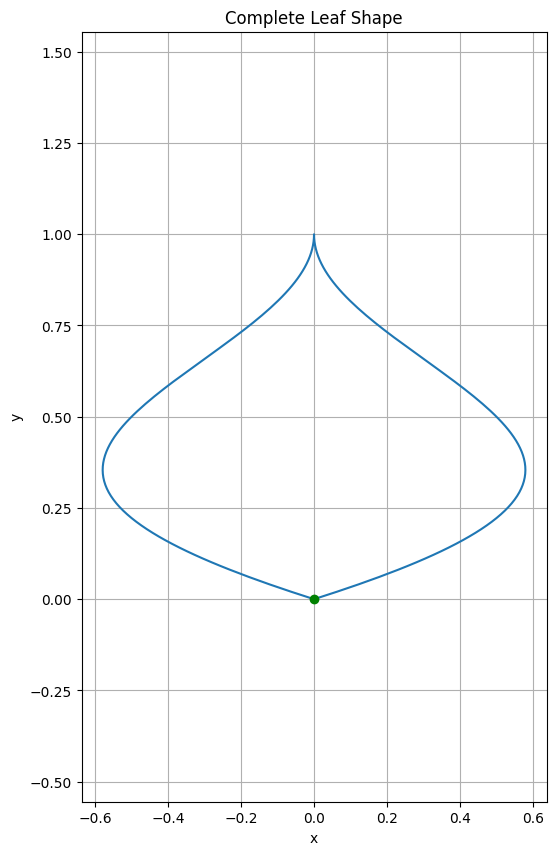

In [116]:
veins, auxinSources, x, y = resetSimulation(veins, auxinSources, x, y)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

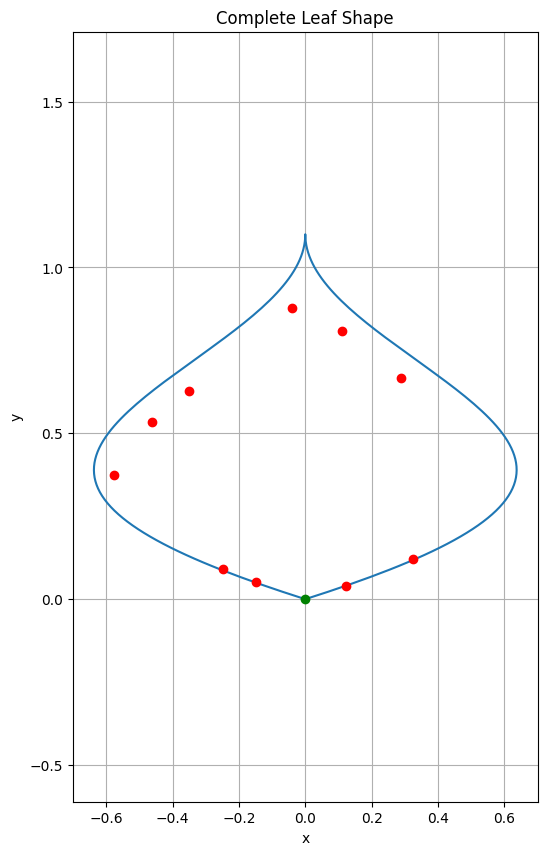

Direction -0.7174734560517844, 3.549782922364896


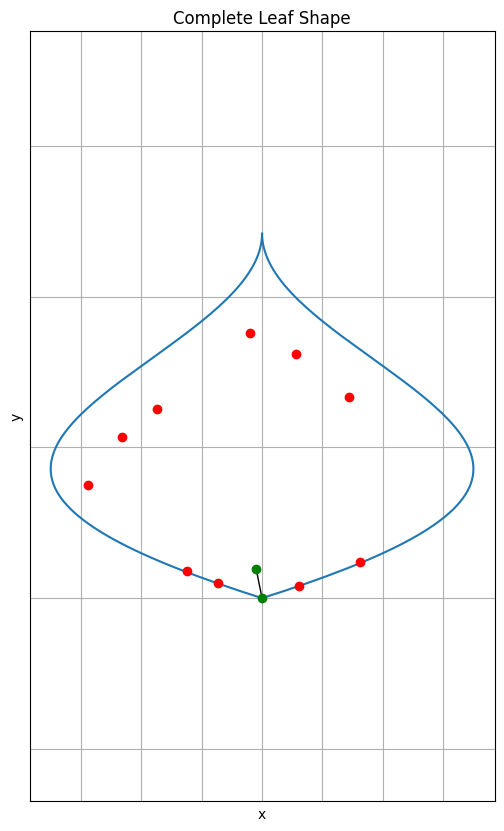

Direction 0.28498804782250114, 0.09371132588070552
Direction -0.9047139545624574, 2.7883077164283896


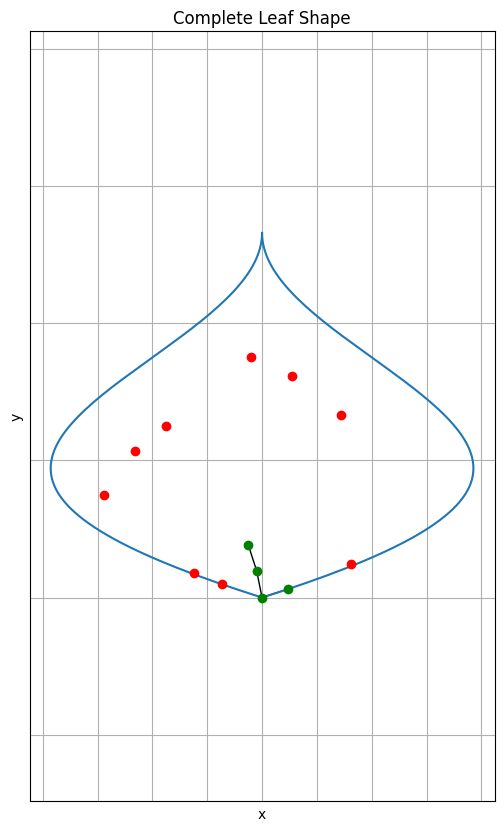

Direction -0.281166721364519, -0.10461966735335643
Direction 0.27953914729661644, 0.1088938250254833
Direction -0.7781020997435791, 2.3766187587821217


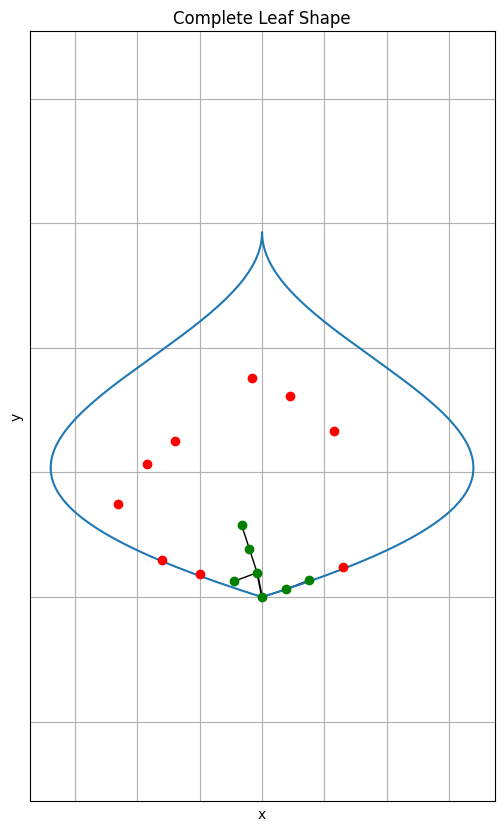

Direction -0.9653093488346798, 0.25832960106109665
Direction 0.27953914729661644, 0.1088938250254833
Direction -0.3144134477168522, 2.186021984997578


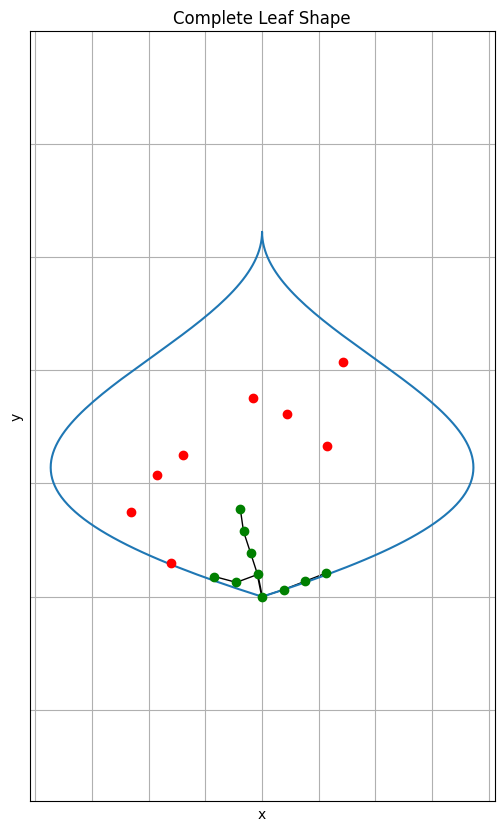

Direction -0.8395730098519372, 0.5176535156960818
Direction 0.5410429615339915, 2.2688984281408913


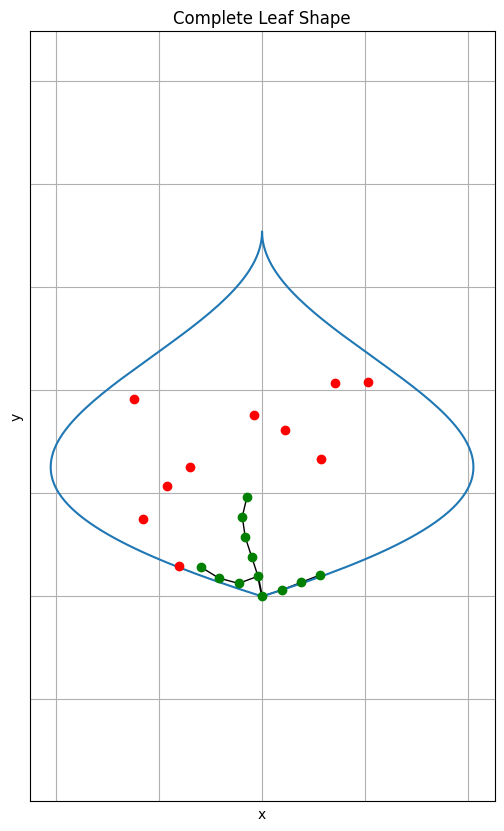

Direction -0.8394076087832016, 0.4638151715248109
Direction 0.392221047372601, 2.5740036581116317


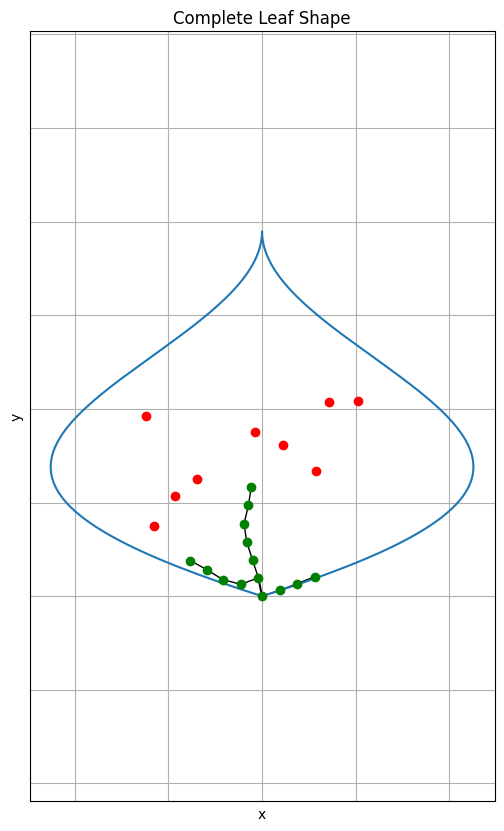

Direction -0.37624169180806516, 0.8881935767598325
Direction 0.7329484576627852, 2.0504249684917784


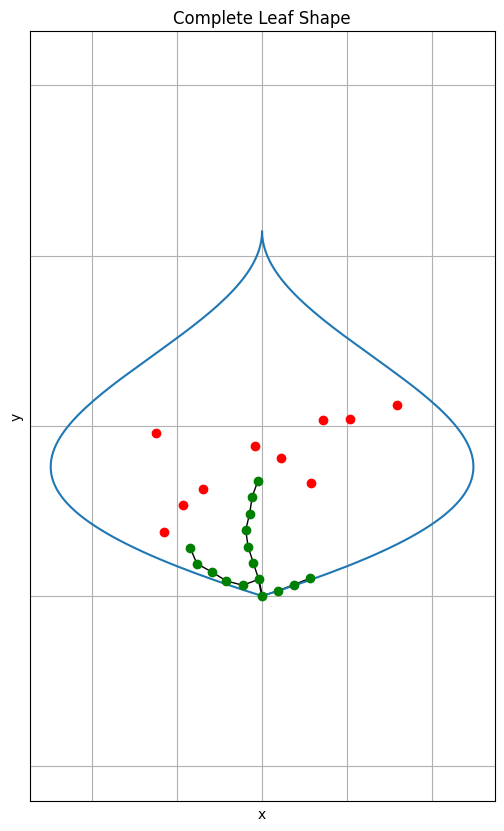

Direction -0.29678357453904, 0.043812211583417256
Direction -0.3707459646289333, 0.8437924924835873
Direction 1.497289702378736, 1.8247292238322053


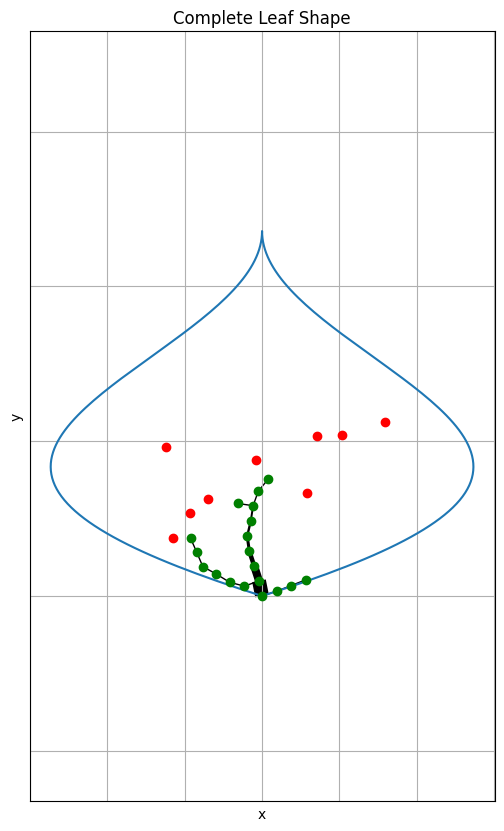

Direction -0.8493532891342228, 0.47354085911834504
Direction -0.3047616279579119, 0.7008352623209477
Direction 1.733990480657662, 1.0689887708475205


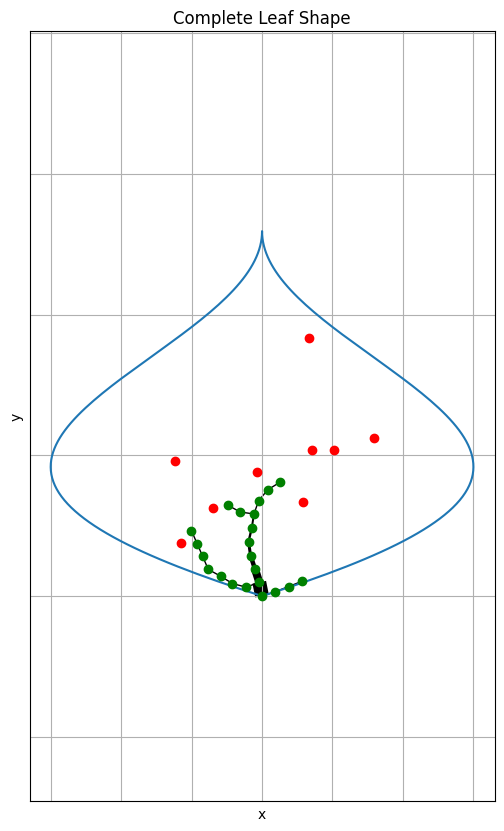

picking random y, before 0.0008514658009605768
after 0.37465146580096054
Direction -0.2999987916742162, 0.37465146580096054
Direction -0.16005488405842777, 0.25373693875556086
Direction -0.8335857093578977, 0.3897565811185432
Direction 1.6228176567654036, 1.2849244326327165


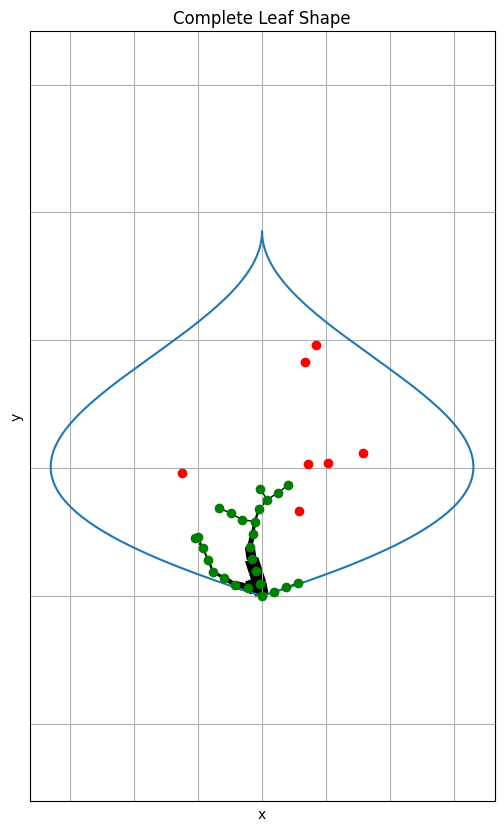

Direction 0.2277328229892871, -0.19528891758963185
Direction -0.21833956651462672, 0.20573729291065557
Direction 1.228698903978207, 1.8924875534283507


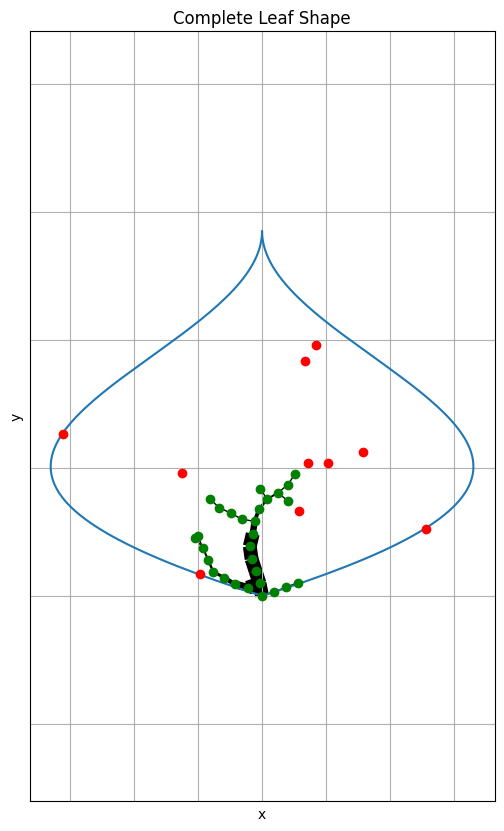

Direction 0.27718787287626007, 0.1147470397454083
Direction -0.29610426741424034, -0.04818986220229385
Direction 0.22773282298928704, -0.19528891758963196
Direction -0.8583271936667887, 0.48931415566949443
Direction 1.2474707540119376, 1.761493157633383


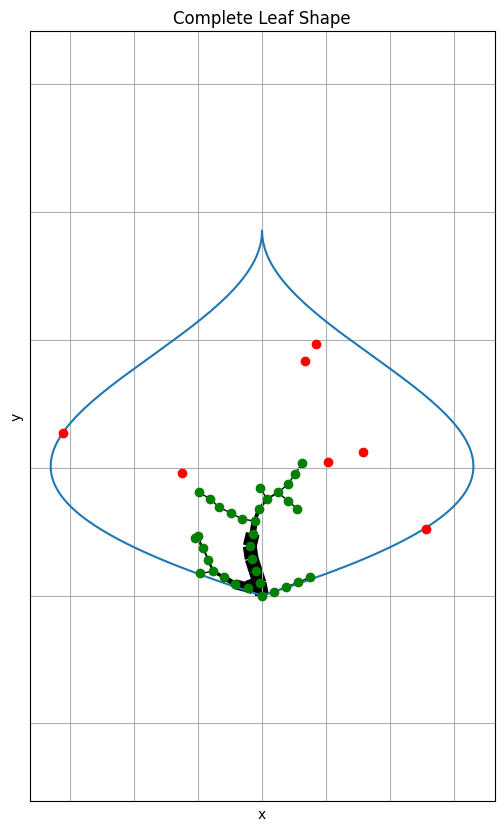

Direction 0.27718787287626, 0.11474703974540831
Direction -0.8349389845127793, 0.5080920724366502
Direction 0.8167506704426621, 1.3496810557312737


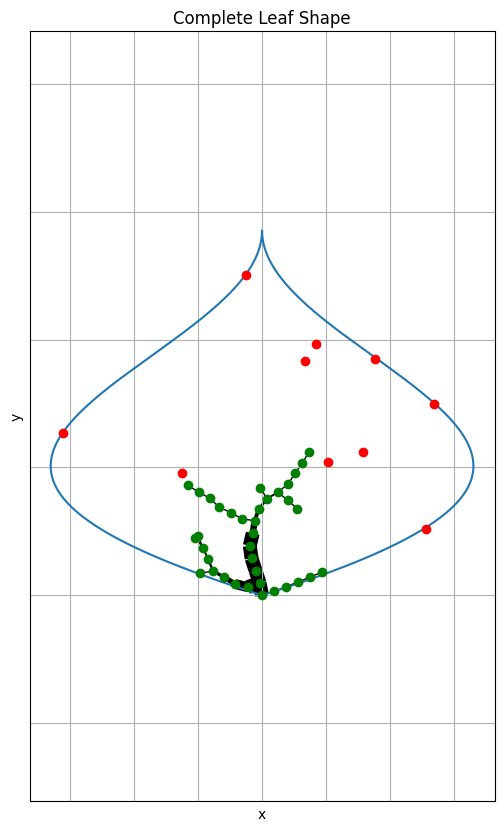

Direction 0.27718787287626, 0.11474703974540833
Direction -0.7623534971895944, 0.5461574102940914
Direction 1.3295607819674593, 2.140035278103304


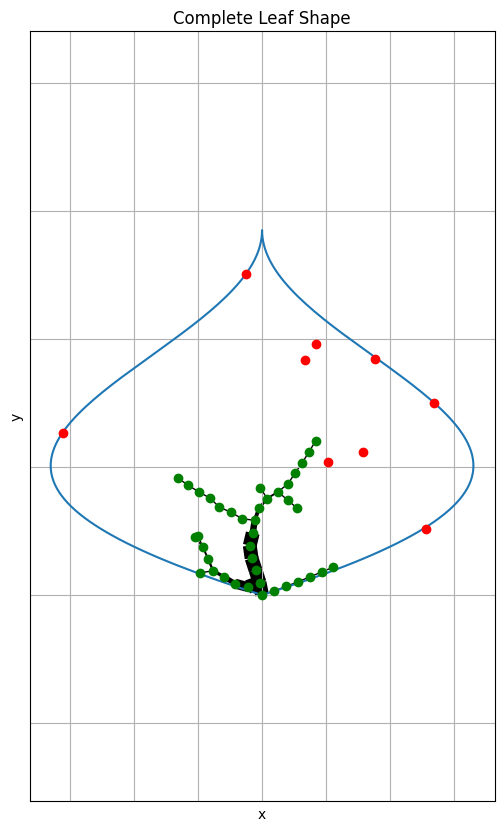

Direction 0.26411306551680647, -0.1422824255602746
Direction 0.27718787287626, 0.11474703974540833
Direction -0.27945954289926367, 0.10909795544617049
Direction 0.8813772299208178, 2.0407864113540484


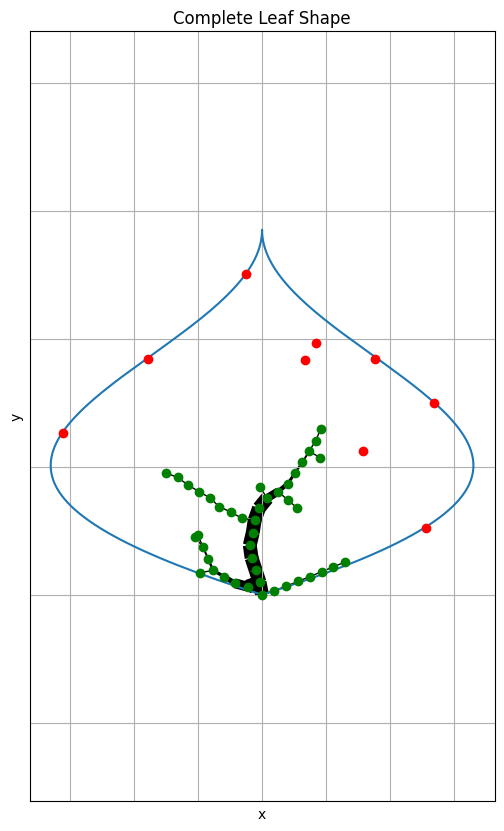

Direction 0.29687562792463645, 0.04318404270506442
Direction 0.27718787287626, 0.1147470397454083
Direction -0.3884455350050813, 0.8005616591390762
Direction 0.49703658617476715, 1.849500852424669


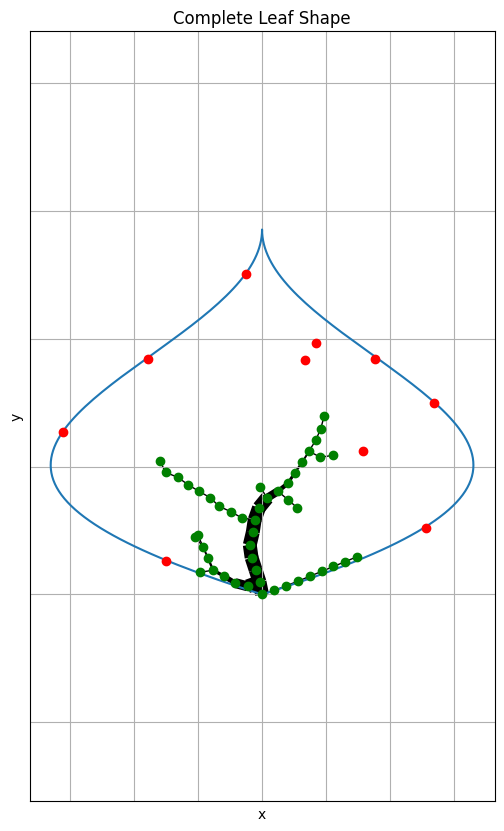

Direction -0.2855545367509679, 0.09197068305139484
Direction 0.2968756279246364, 0.043184042705064395
Direction 0.27718787287625996, 0.11474703974540831
Direction -0.37172557490081465, 0.7797514634917591
Direction 0.4490592924753939, 1.7415596242834814


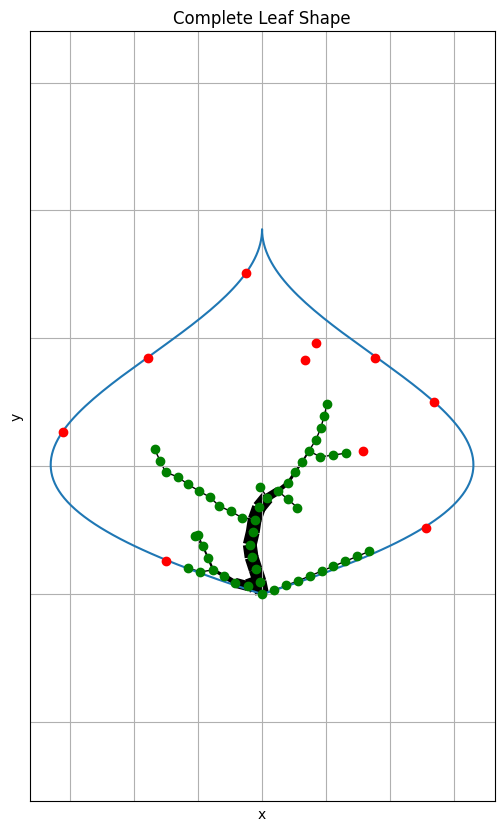

Direction -0.2855545367509679, 0.09197068305139482
Direction 0.9041131512429597, 0.3914118277455875
Direction 0.27718787287626, 0.11474703974540833
Direction -0.7107147648194528, 0.42769157540308406
Direction -0.1758057846419369, 1.6747366633534368


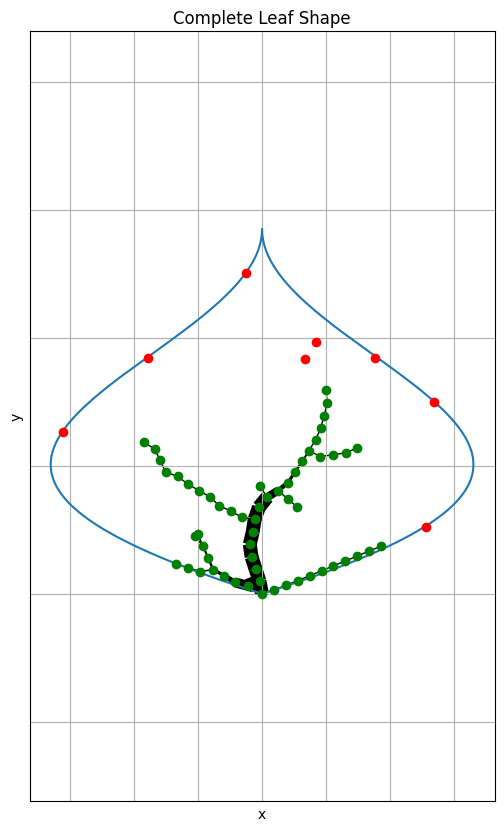

Direction 0.2578220026171175, 0.15338779275580908
Direction 0.27718787287626, 0.11474703974540833
Direction -0.2635809182897845, 0.7380534237956404
Direction -0.17936448048889675, 1.5621181533705808


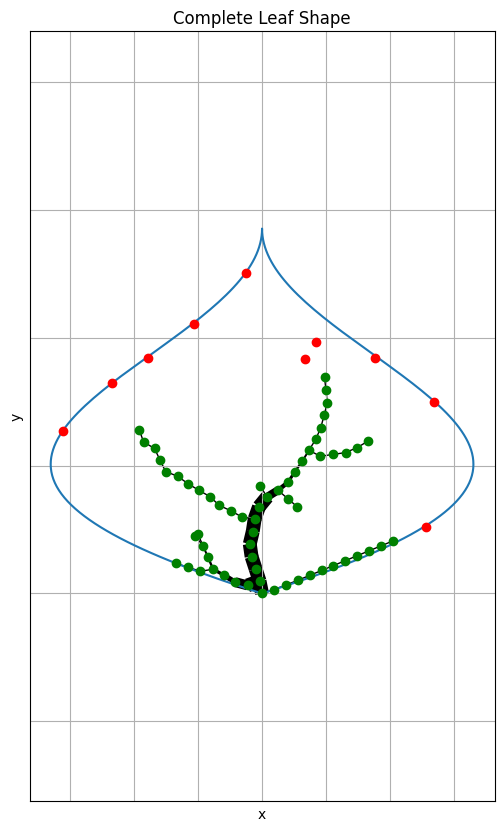

Direction 0.25782200261711746, 0.1533877927558091
Direction 0.27718787287626, 0.11474703974540833
Direction -0.3479455620743309, 1.2990181689287563
Direction -0.21508339834347406, 1.3913719757906249


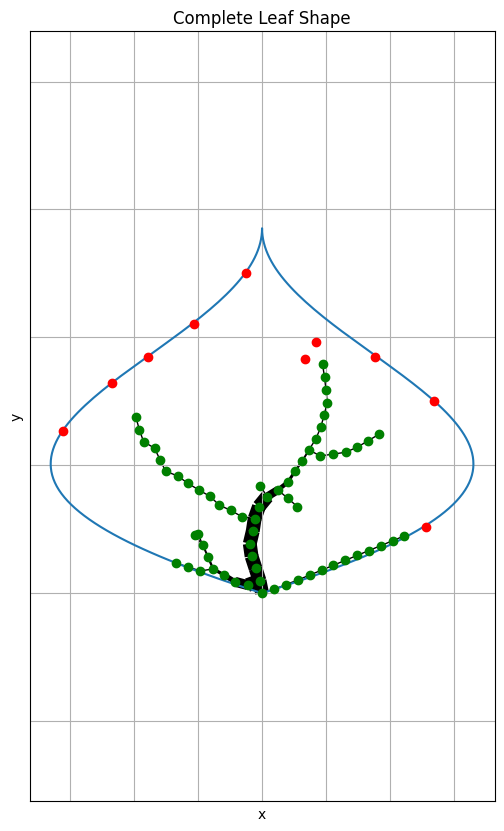

Direction 0.25782200261711746, 0.15338779275580916
Direction 0.27718787287626, 0.11474703974540834
Direction -0.27815803642716147, 1.158996911370703
Direction -0.2949253156934994, 1.1238381582469197


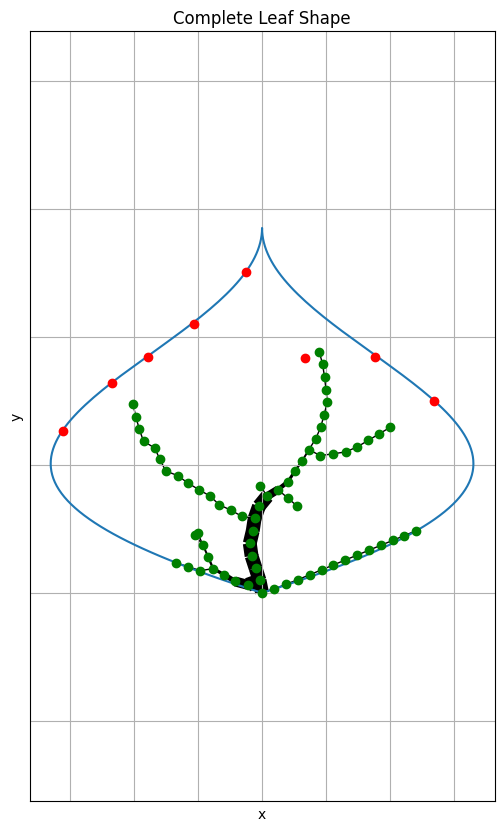

Direction -0.29482627141417, -0.05547494645349533
Direction 0.2972478131617835, 0.04054303356357837
Direction 0.25782200261711746, 0.15338779275580913
Direction 0.3591724386873202, 1.2498862638003905
Direction -0.7471683340121391, 0.3952485040178192


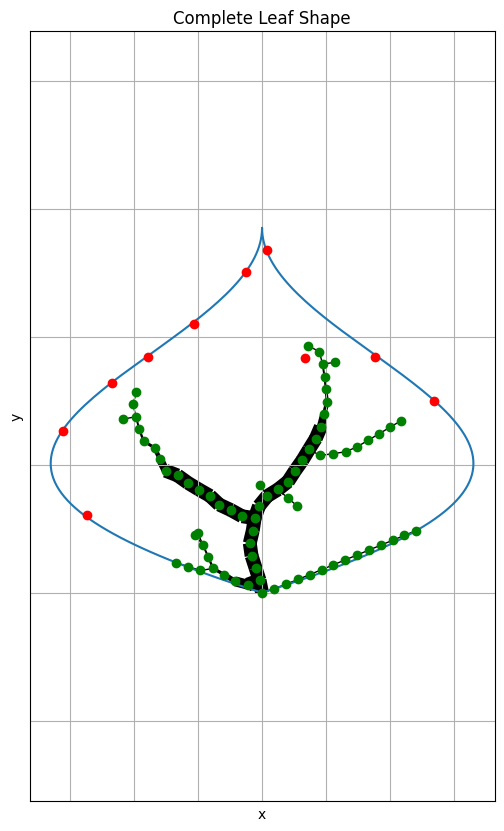

Direction -0.26128794259985433, -0.1474062788755459
Direction -0.29482627141416995, -0.055474946453495336
Direction 0.2972478131617835, 0.040543033563578454
Direction 0.2578220026171175, 0.15338779275580916
Direction 0.32049814489223405, 1.1184499351102337
Direction -0.6776086815746206, 0.7370873387057238


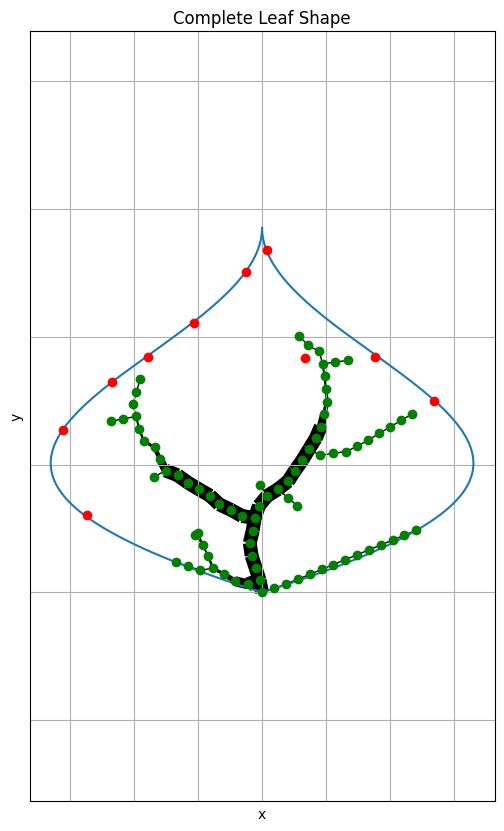

Direction -0.28074028292162406, 0.1057586570692276
Direction -0.07964187144212613, -0.28923549628839795
Direction -0.2612879425998544, -0.1474062788755459
Direction -0.29482627141417, -0.055474946453495405
Direction 0.29724781316178345, 0.04054303356357861
Direction 0.25782200261711746, 0.15338779275580916
Direction 0.5799308003344429, 0.7893021794301426
Direction -0.4383195236253738, 0.8862857677485323


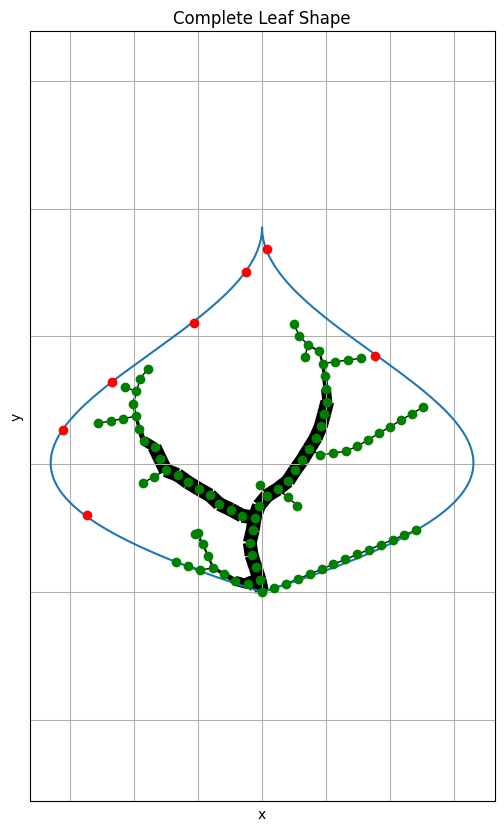

Direction -0.28074028292162406, 0.10575865706922762
Direction -0.26128794259985433, -0.14740627887554586
Direction -0.2948262714141699, -0.0554749464534955
Direction 0.2972478131617835, 0.04054303356357843
Direction 0.21340167296642726, 0.21085475089532613
Direction -0.4373759759559297, 0.882040386552703


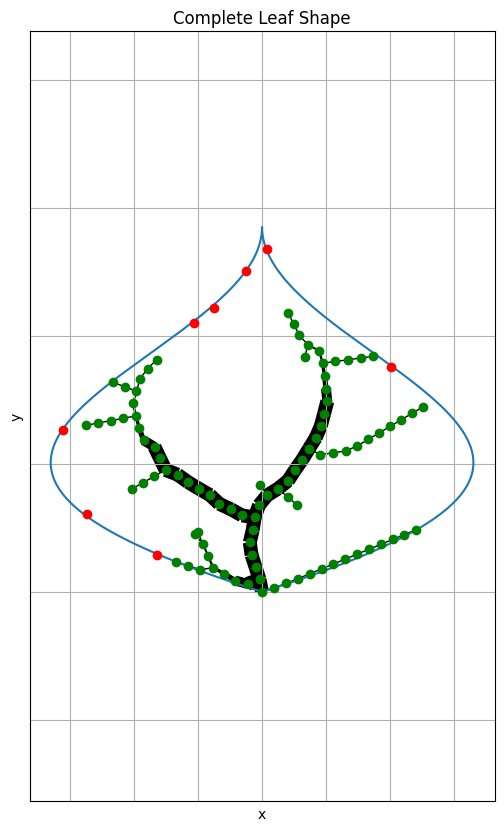

Direction -0.2819928249341643, 0.1023720991562143
Direction -0.2612879425998544, -0.14740627887554583
Direction -0.29482627141416995, -0.05547494645349537
Direction 0.25583724580880685, -0.15667579154727174
Direction 0.21340167296642729, 0.21085475089532613
Direction -1.070702099468672, 0.7272022362986413


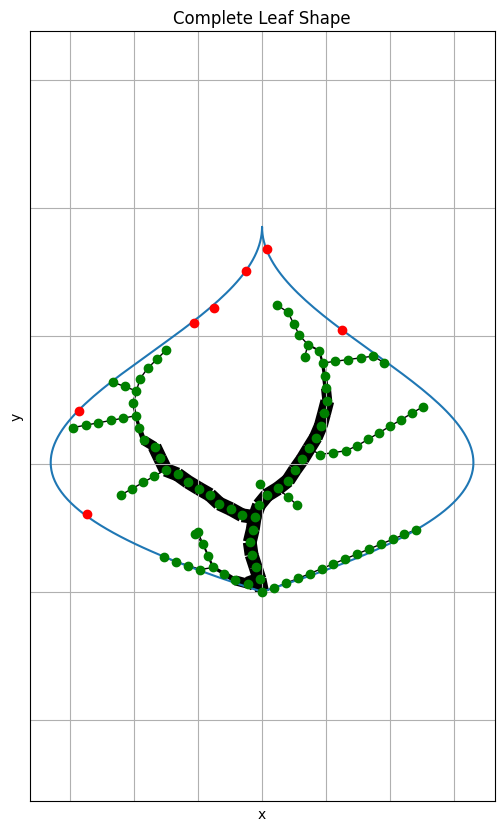

Direction -0.06220495138764558, 0.29348005728304716
Direction -0.1293232765237419, 0.27069445902929706
Direction -0.2612879425998544, -0.1474062788755458
Direction 0.21340167296642726, 0.21085475089532607
Direction -0.9946033178852954, 0.6830178233264147


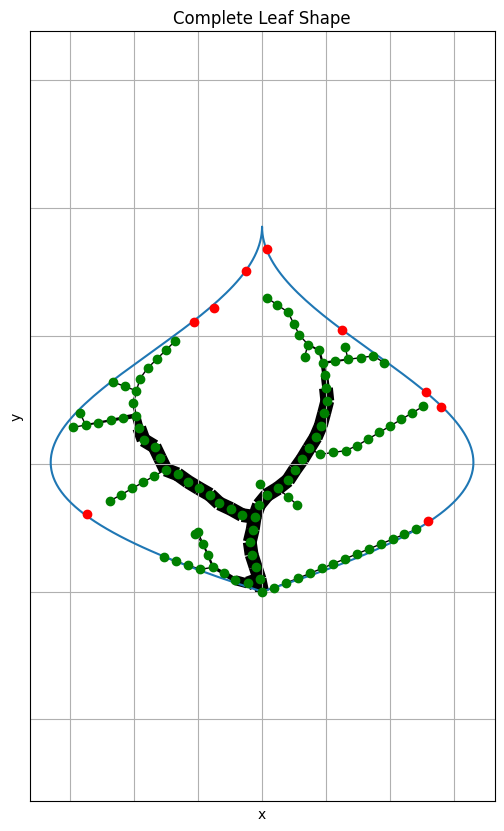

Direction 0.24697771771010024, 0.1702997561792442
Direction 0.7636576525880963, 0.2578688475598402
Direction -0.06220495138764548, 0.2934800572830472
Direction -0.26128794259985444, -0.14740627887554572
Direction 0.7436644412212479, 0.6678245492438978
Direction -0.18397456511448138, 0.9387187931623876


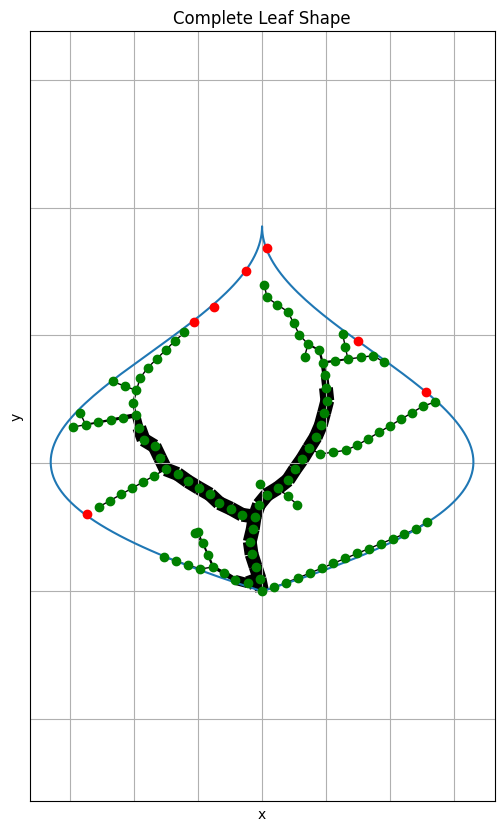

Direction 0.27230254529372944, 0.12590204059726928
Direction -0.20442568871979303, 0.21956807097444353
Direction -0.2612879425998546, -0.14740627887554547
Direction 0.737328558281175, 0.6733469749263188
Direction -0.19062841766954935, 0.8854227236605502


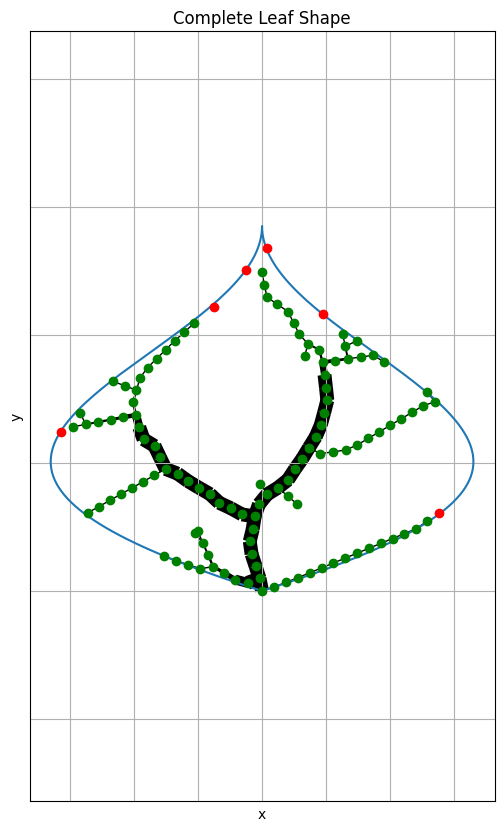

Direction -0.27136114566075625, -0.12791844521288473
Direction 0.2505176593212264, 0.16504818195973542
Direction -0.21142733526356483, 0.21283440018791172
Direction 0.23196951615353562, 0.19023707203248938
Direction -0.1549483465921209, 0.7205571212260027


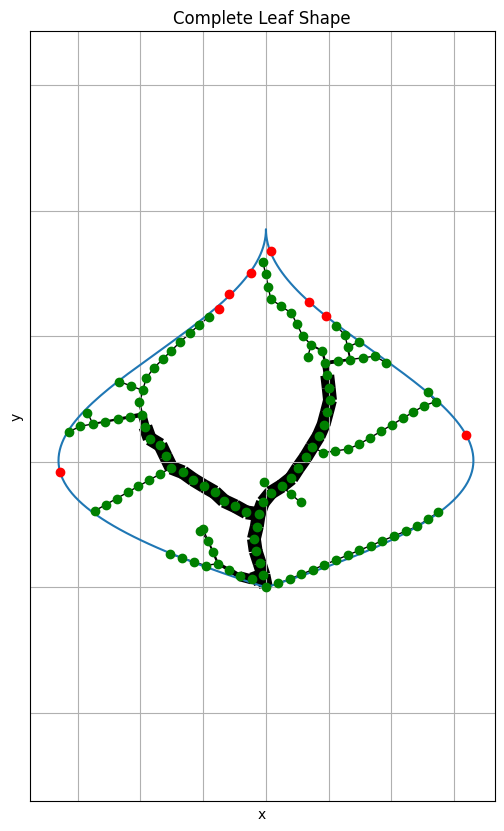

Direction 0.2507786261295363, 0.1646513913593878
Direction 0.19948091711416074, -0.22406999733854002
Direction -0.2979145052155778, 0.03531214496681668
Direction -0.0645818046705998, -0.29296619345154573
Direction -0.21142733526356508, 0.21283440018791147
Direction 0.703085705580678, 0.7079720776672727
Direction 0.16739987732579883, 0.24895236707311602


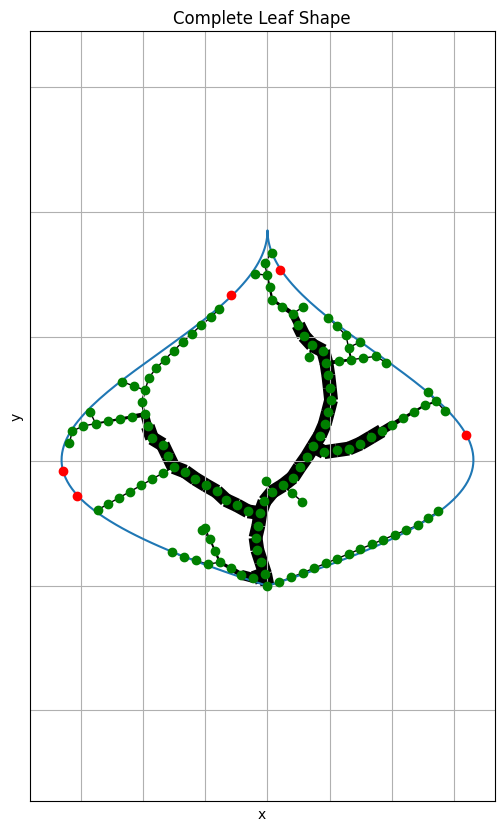

Direction -0.24755147627078564, 0.16946464703930036
Direction 0.2765211732100908, 0.11634449177556697
Direction 0.1994809171141608, -0.22406999733853994
Direction -0.06458180467059985, -0.2929661934515457
Direction 0.1950444457306362, 0.2279422387132953


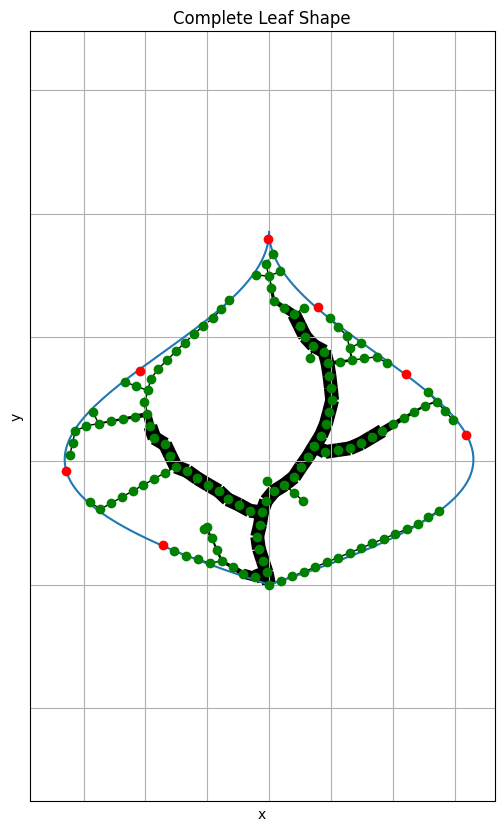

Direction -0.24408685656864113, 0.17441790748211497
Direction -0.2635080887562136, 0.1433997460250451
Direction 0.26040896891218634, -0.14895357971560122
Direction 0.2990837300797047, 0.023429093059919297
Direction -0.08763583754703765, 0.2869145517003786
Direction 0.19948091711416097, -0.22406999733853983
Direction -0.06458180467059996, -0.2929661934515457


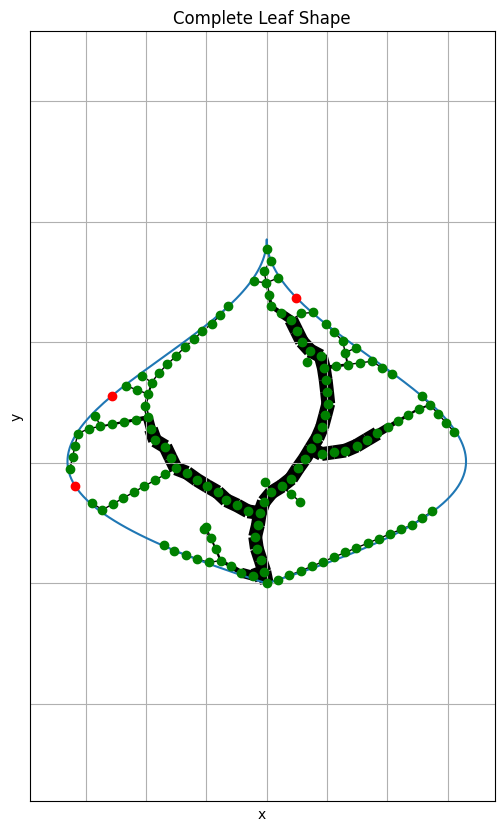

Direction -0.24136816326462016, -0.1781611903930361
Direction -0.09841308022194159, 0.283398774946593
Direction 0.08179287297088723, -0.2886345889375844


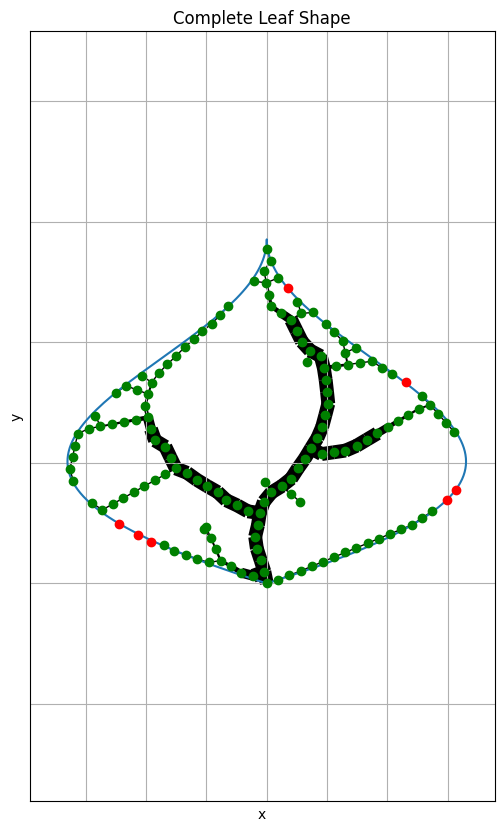

Direction 0.0875393858901849, -0.28694399439258056
Direction 0.759763459268627, 0.6487063982175711
Direction 0.21296665516329683, -0.21129411678642976
Direction -0.9359247399519175, 0.34833690079635254
Direction 0.25524751438965887, -0.15763472459423689


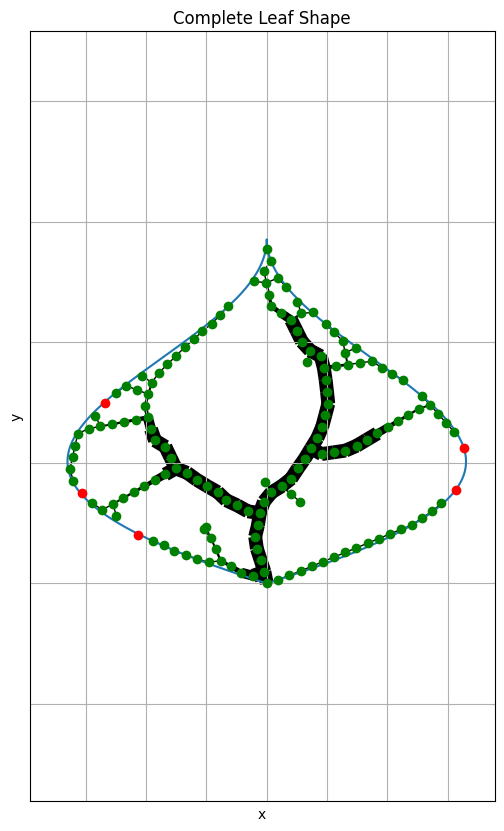

Direction -0.21989781031206887, 0.2040709509458839
Direction 0.15887224044143597, -0.25447909780003264
Direction -0.22796084673449216, -0.19502269702804692
Direction 0.21896759097084148, 0.20506875457861995
Direction -0.27429636964416776, 0.12149692012569718


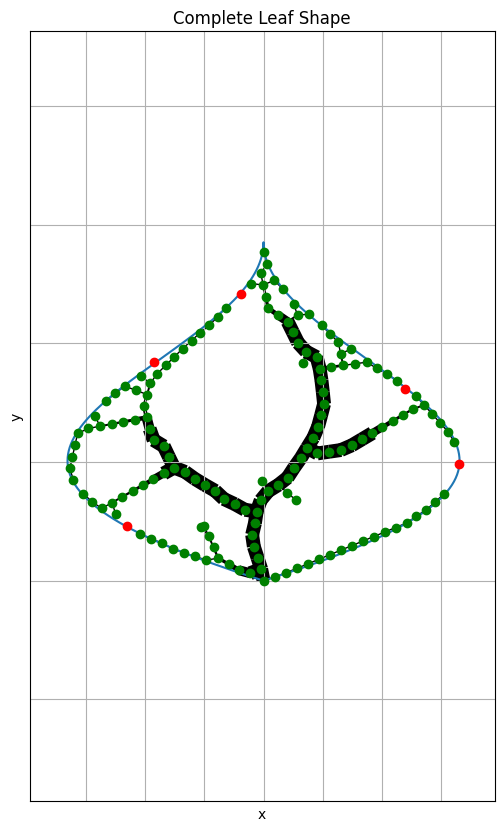

Direction -0.28808260501711014, 0.08371626297533655
Direction -0.21960119281273893, -0.20439010767456986
Direction 0.2065678927501076, -0.21755391443221622
Direction 0.06725588960906101, -0.2923638919444291
Direction -0.2579950852334425, 0.15309649243333032


KeyboardInterrupt: 

In [132]:
veins, auxinSources, x, y = resetSimulation(veins, auxinSources, x, y)

for i in range(50):
    buckets = getBuckets(veins, auxinSources)
    newVeinNodesAdded = addVeinsForBuckets(buckets, veins, distanceVeinGrows)
    veins = updateWidthForNewVeinNodes(newVeinNodesAdded, veins, murraysLawExponent)

    for j in range(numberOfAuxinSources - len(auxinSources)):
        addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold)

    auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
    x,y = growLeaf(baseX, baseY, x, y, i)

    plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

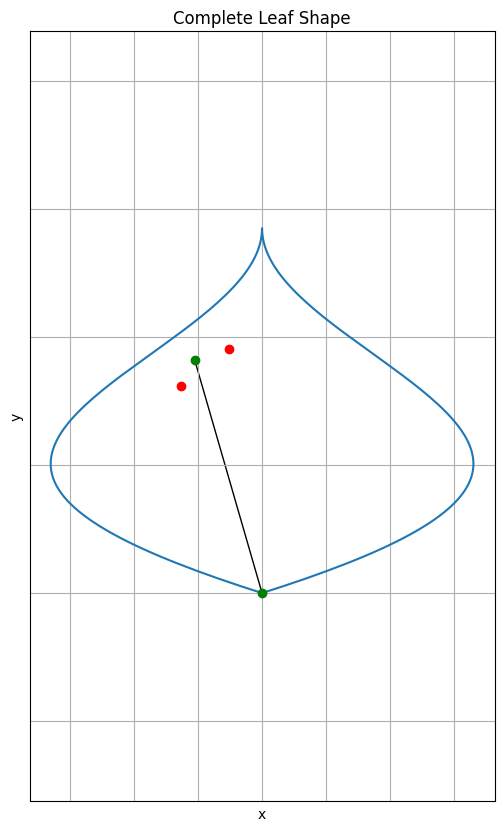

Node 0, (0, 0)
Node 1, (-0.5262823062311709, 1.820825037594356)
Direction 0.5276152676644505, -0.05361693146865806


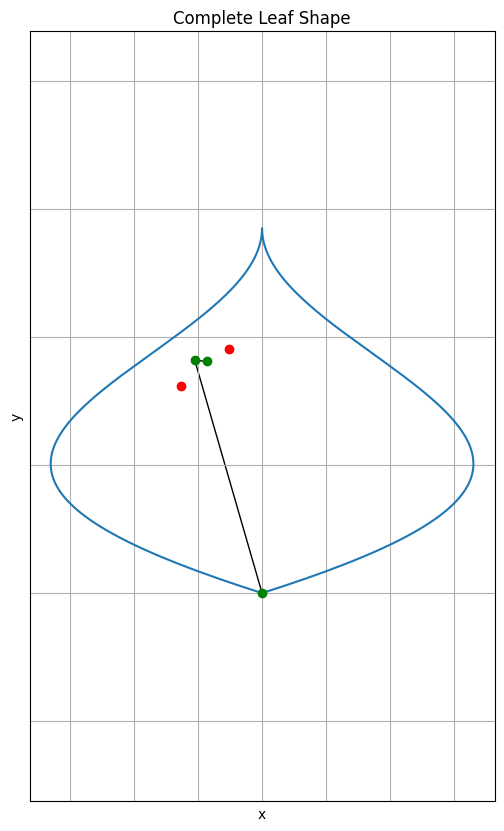

Node 0, (0, 0)
Node 1, (-0.5262823062311709, 1.820825037594356)
Node 2, (-0.42679468525593645, 1.8107149795980786)
Direction -0.13952094313810637, -0.26558220276564704
Direction 0.2608890221554073, 0.14811116810961755


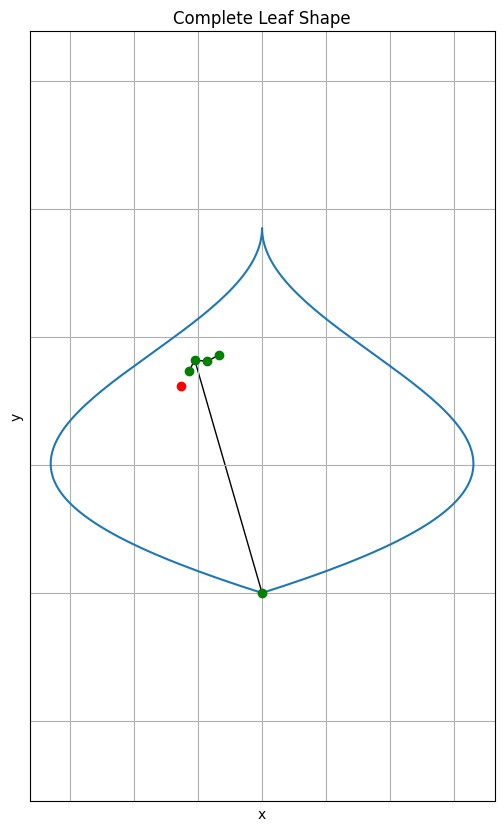

Node 0, (0, 0)
Node 1, (-0.5262823062311709, 1.820825037594356)
Node 2, (-0.42679468525593645, 1.8107149795980786)
Node 3, (-0.5727892872772063, 1.7322976366724736)
Node 4, (-0.33983167787080065, 1.860085368967951)
Direction -0.13952094313810642, -0.265582202765647


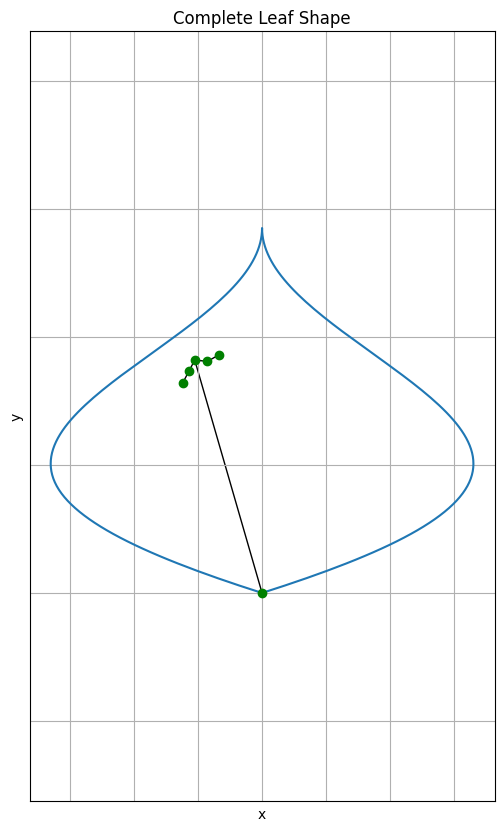

Node 0, (0, 0)
Node 1, (-0.5262823062311709, 1.820825037594356)
Node 2, (-0.42679468525593645, 1.8107149795980786)
Node 3, (-0.5727892872772063, 1.7322976366724736)
Node 4, (-0.33983167787080065, 1.860085368967951)
Node 5, (-0.6192962683232418, 1.6437702357505912)


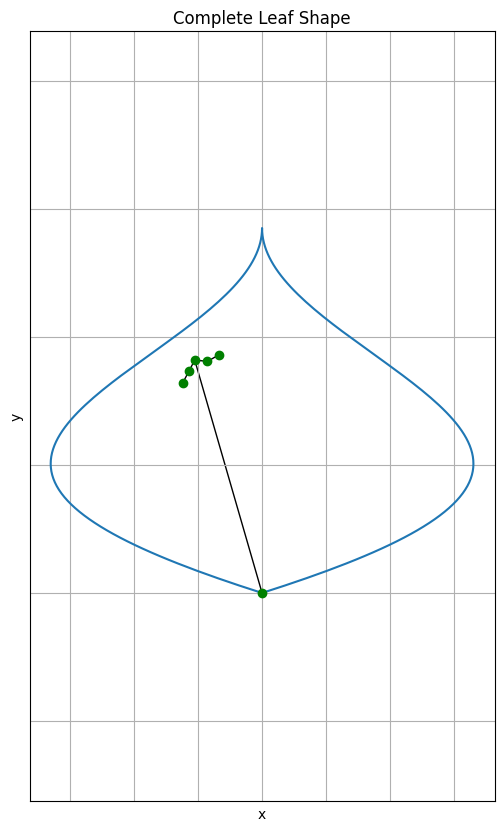

Node 0, (0, 0)
Node 1, (-0.5262823062311709, 1.820825037594356)
Node 2, (-0.42679468525593645, 1.8107149795980786)
Node 3, (-0.5727892872772063, 1.7322976366724736)
Node 4, (-0.33983167787080065, 1.860085368967951)
Node 5, (-0.6192962683232418, 1.6437702357505912)


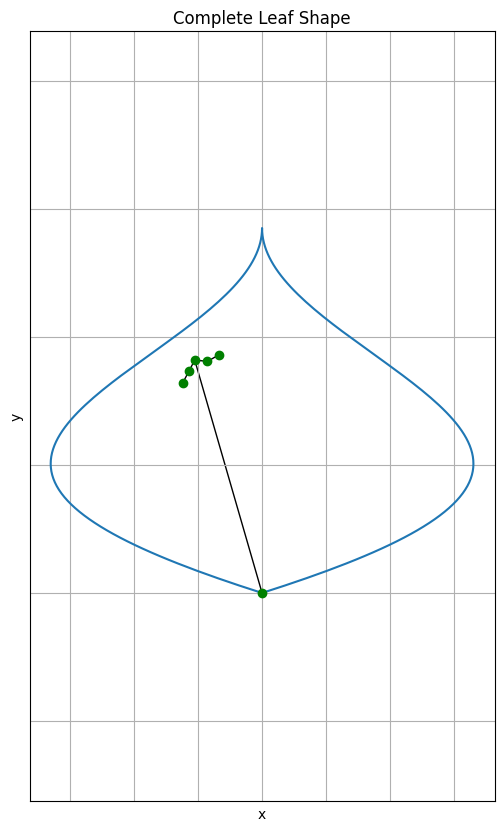

Node 0, (0, 0)
Node 1, (-0.5262823062311709, 1.820825037594356)
Node 2, (-0.42679468525593645, 1.8107149795980786)
Node 3, (-0.5727892872772063, 1.7322976366724736)
Node 4, (-0.33983167787080065, 1.860085368967951)
Node 5, (-0.6192962683232418, 1.6437702357505912)


In [119]:
veins, auxinSources, x, y = resetSimulation(veins, auxinSources, x, y)
for i in range(15):
    x,y = growLeaf(baseX, baseY, x, y, i)

auxinSources = [[-0.6319548425015065, 1.619674268947901], [-0.2599113137264044, 1.9054575290971012]]
veins.add_node(1, x=-0.5262823062311709,y=1.820825037594356)
veins.add_edge(0, 1, width=1)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

for idx in range(len(veins.nodes())):
    print(f'Node {idx}, ({veins.nodes()[idx]["x"]}, {veins.nodes()[idx]["y"]})')

for i in range(5):
    buckets = getBuckets(veins, auxinSources)
    newVeinNodesAdded = addVeinsForBuckets(buckets, veins, distanceVeinGrows)

    # veinsX, veinsY = getVeinPositionList(veins)
    # print(dict(zip(veins.nodes, zip(veinsX, veinsY))))

    auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
    plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

    for idx in range(len(veins.nodes())):
        print(f'Node {idx}, ({veins.nodes()[idx]["x"]}, {veins.nodes()[idx]["y"]})')

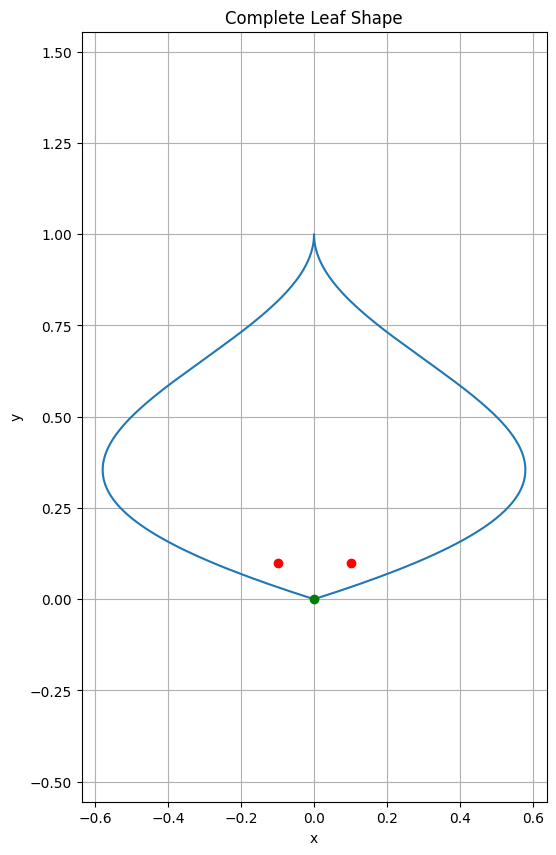

picking random x, before 3.5355073896292666e-06
after 0.10000453550738964


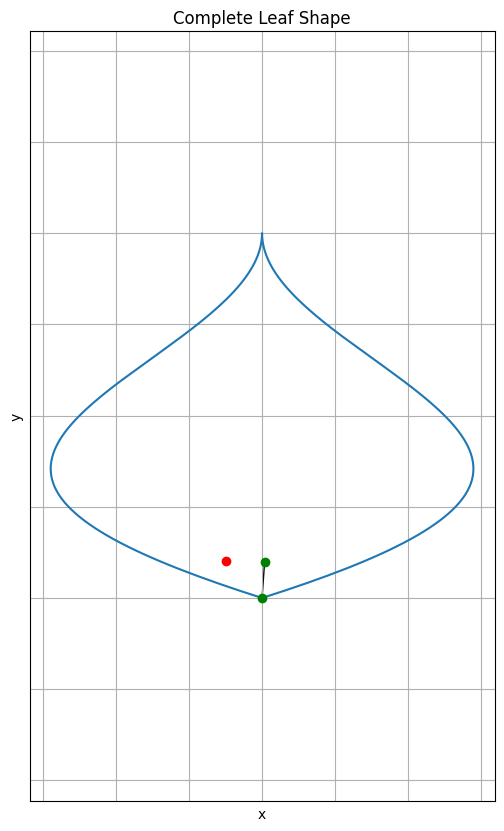

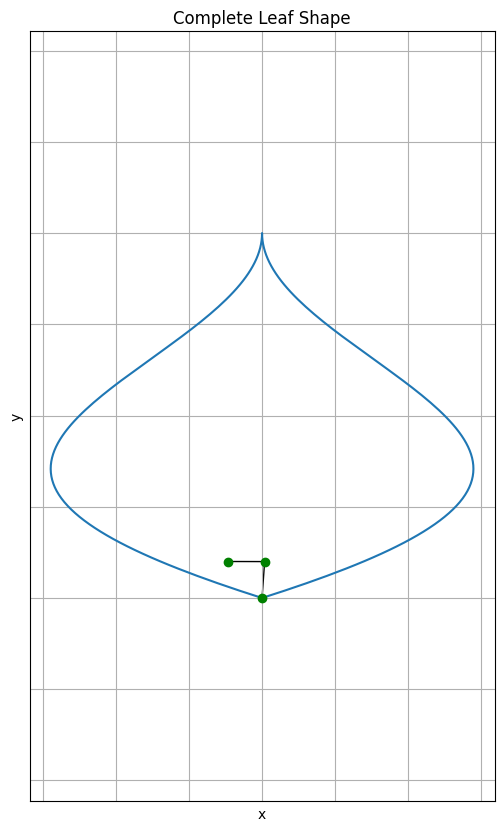

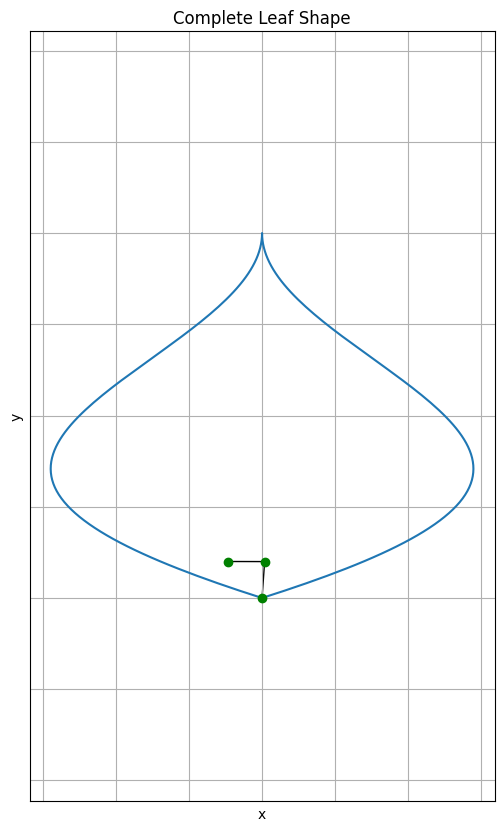

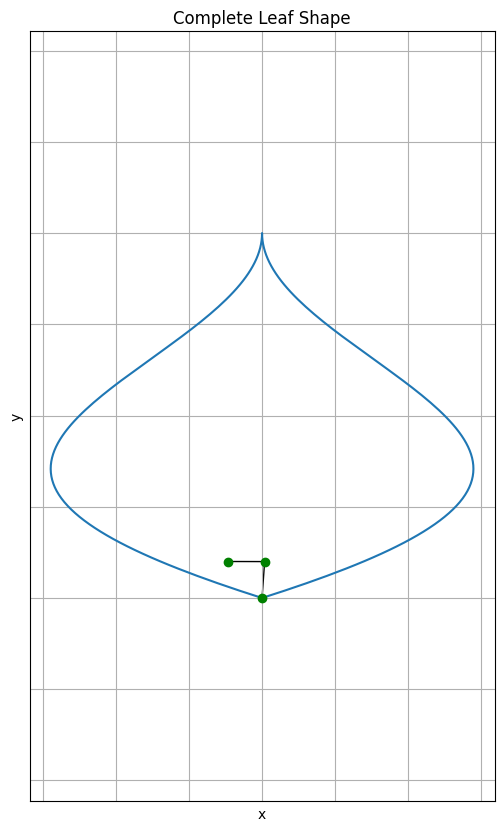

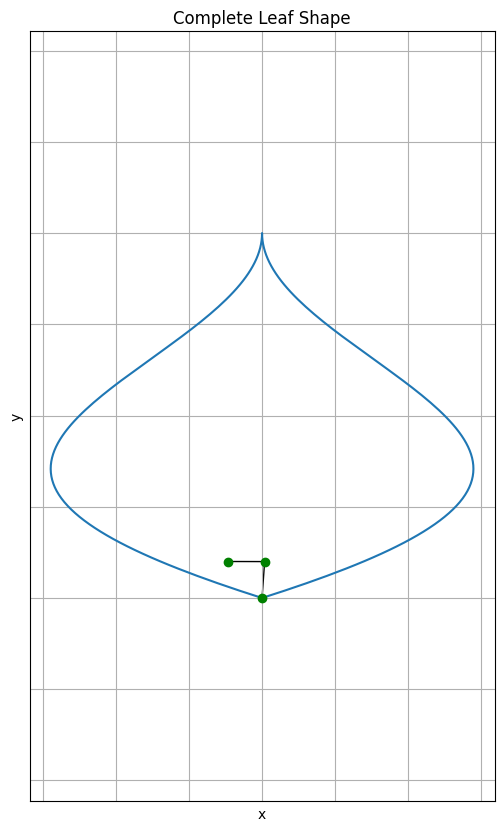

In [ ]:
def testVerySmallDirectionVectorForVeinsToSources(veins, auxinSources, x, y):
    veins, auxinSources, x, y = resetSimulation(veins, auxinSources, x, y)

    auxinSources = [[0.100001, 0.1], [-0.1, 0.1]]
    plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

    for i in range(5):
        buckets = getBuckets(veins, auxinSources)
        newVeinNodesAdded = addVeinsForBuckets(buckets, veins, distanceVeinGrows)

        # veinsX, veinsY = getVeinPositionList(veins)
        # print(dict(zip(veins.nodes, zip(veinsX, veinsY))))

        auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
        plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

testVerySmallDirectionVectorForVeinsToSources(veins, auxinSources, x, y)